Initializing Model...
Loading weights from /kaggle/input/havmodel/best_model.pth...
Model Loaded Successfully!

--- EXPLAINING PREDICTION FOR: sample_video2.mp4 ---
Prediction: FAKE (Confidence: 0.9072)


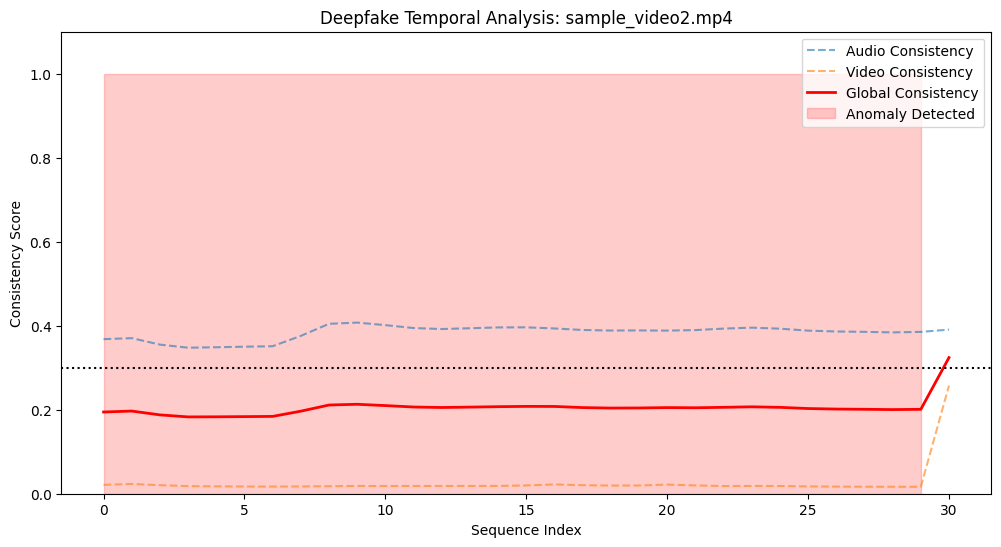

Anomaly Detected at sequence indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Displaying representative suspicious frame...


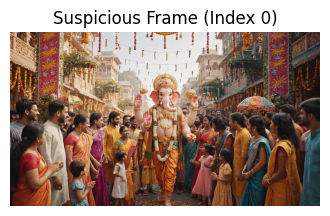

In [3]:
# =================================================================================
# EXPLAINABILITY & INFERENCE NOTEBOOK
# =================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import os
import math
import matplotlib.pyplot as plt

# =================================================================================
# 1. CONFIGURATION (MUST MATCH TRAINING EXACTLY)
# =================================================================================
class Config:
    # --- PATHS ---
    # UPDATE THIS to the path of your added notebook output
    # Check the right panel in Kaggle to find the exact name
    MODEL_CHECKPOINT_PATH = "/kaggle/input/havmodel/best_model.pth" 
    
    # Path to a video you want to test (Change this to a real file path)
    TEST_VIDEO_PATH = "/kaggle/input/custom-data/custom data/sample_video2.mp4"

    # --- HYPERPARAMETERS ---
    HIDDEN_DIM = 128
    SEQUENCE_LENGTH = 32
    IMG_SIZE = 112
    AUDIO_SAMPLE_RATE = 16000
    AUDIO_N_MELS = 64
    AUDIO_N_FFT = 1024
    DROPOUT_RATE = 0.5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()

# =================================================================================
# 2. MODEL ARCHITECTURE (REQUIRED FOR LOADING WEIGHTS)
# =================================================================================
# We must redefine the classes exactly as they were during training.

class AudioFeatureExtractor(nn.Module):
    def __init__(self, input_dim=config.AUDIO_N_MELS, hidden_dim=config.HIDDEN_DIM, num_layers=2):
        super(AudioFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1), nn.BatchNorm2d(16), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2), nn.Dropout2d(config.DROPOUT_RATE),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2), nn.Dropout2d(config.DROPOUT_RATE),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((2, 2))
        )
        self.temporal_dim = 64 * 2 * 2
        self.temporal_projection = nn.Linear(self.temporal_dim, hidden_dim)
        self.positional_encoding = self._create_positional_encoding(config.SEQUENCE_LENGTH, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 2, dropout=config.DROPOUT_RATE, activation='gelu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Sequential(nn.LayerNorm(hidden_dim), nn.Dropout(config.DROPOUT_RATE), nn.Linear(hidden_dim, hidden_dim))

    def _create_positional_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, audio_input):
        batch_size, seq_len, n_mels, time_frames = audio_input.shape
        audio_reshaped = audio_input.reshape(-1, 1, n_mels, time_frames)
        conv_features = self.conv_layers(audio_reshaped).reshape(-1, self.temporal_dim)
        temporal_features = self.temporal_projection(conv_features).reshape(batch_size, seq_len, -1)
        pos_encoding = self.positional_encoding[:, :seq_len, :].to(audio_input.device)
        output_features = self.output_projection(self.transformer_encoder(temporal_features + pos_encoding))
        return output_features

class AudioTemporalConsistencyModule(nn.Module):
    def __init__(self, feature_dim=256):
        super(AudioTemporalConsistencyModule, self).__init__()
        self.temporal_diff_encoder = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim), nn.LayerNorm(feature_dim), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(feature_dim, feature_dim // 2), nn.LayerNorm(feature_dim // 2), nn.GELU(), nn.Linear(feature_dim // 2, 1)
        )
    def forward(self, audio_features):
        batch_size, seq_len, _ = audio_features.shape
        consistency_scores = []
        for i in range(seq_len - 1):
            frame_pair = torch.cat([audio_features[:, i, :], audio_features[:, i + 1, :]], dim=1)
            consistency_scores.append(torch.sigmoid(self.temporal_diff_encoder(frame_pair)))
        return torch.cat(consistency_scores, dim=1)

class SpatialAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SpatialAttentionModule, self).__init__()
        self.channel_attention = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_channels, in_channels // reduction_ratio, 1), nn.ReLU(inplace=True), nn.Conv2d(in_channels // reduction_ratio, in_channels, 1), nn.Sigmoid())
        self.spatial_attention = nn.Sequential(nn.Conv2d(2, 1, kernel_size=7, padding=3), nn.Sigmoid())
    def forward(self, x):
        x = x * self.channel_attention(x)
        spatial_input = torch.cat([torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]], dim=1)
        return x * self.spatial_attention(spatial_input)

class VideoFeatureExtractor(nn.Module):
    def __init__(self, hidden_dim=config.HIDDEN_DIM, num_layers=2):
        super(VideoFeatureExtractor, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=False) # Pretrained doesn't matter for loading weights
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.spatial_attention = SpatialAttentionModule(512)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.spatial_dim = 512 * 2 * 2
        self.temporal_projection = nn.Linear(self.spatial_dim, hidden_dim)
        self.positional_encoding = self._create_positional_encoding(config.SEQUENCE_LENGTH, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 2, dropout=config.DROPOUT_RATE, activation='gelu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Sequential(nn.LayerNorm(hidden_dim), nn.Dropout(config.DROPOUT_RATE), nn.Linear(hidden_dim, hidden_dim))

    def _create_positional_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, video_input):
        batch_size, seq_len, c, h, w = video_input.shape
        video_reshaped = video_input.reshape(-1, c, h, w)
        spatial_features = self.backbone(video_reshaped)
        attended_features = self.spatial_attention(spatial_features)
        pooled_features = self.adaptive_pool(attended_features)
        flattened = pooled_features.reshape(-1, self.spatial_dim)
        temporal_features = self.temporal_projection(flattened).reshape(batch_size, seq_len, -1)
        pos_encoding = self.positional_encoding[:, :seq_len, :].to(video_input.device)
        return self.output_projection(self.transformer_encoder(temporal_features + pos_encoding))

class VideoTemporalConsistencyModule(nn.Module):
    def __init__(self, feature_dim=256):
        super(VideoTemporalConsistencyModule, self).__init__()
        self.frame_diff_encoder = nn.Sequential(nn.Linear(feature_dim * 2, feature_dim), nn.LayerNorm(feature_dim), nn.GELU(), nn.Dropout(0.2), nn.Linear(feature_dim, feature_dim // 2), nn.LayerNorm(feature_dim // 2), nn.GELU(), nn.Linear(feature_dim // 2, 1))
        self.motion_encoder = nn.Sequential(nn.Linear(feature_dim * 3, feature_dim), nn.LayerNorm(feature_dim), nn.GELU(), nn.Dropout(0.2), nn.Linear(feature_dim, feature_dim // 2), nn.LayerNorm(feature_dim // 2), nn.GELU(), nn.Linear(feature_dim // 2, 1))

    def forward(self, video_features):
        batch_size, seq_len, _ = video_features.shape
        frame_scores, motion_scores = [], []
        for i in range(seq_len - 1):
            frame_scores.append(torch.sigmoid(self.frame_diff_encoder(torch.cat([video_features[:, i, :], video_features[:, i + 1, :]], dim=1))))
            if i < seq_len - 2:
                motion_scores.append(torch.sigmoid(self.motion_encoder(torch.cat([video_features[:, i, :], video_features[:, i + 1, :], video_features[:, i + 2, :]], dim=1))))
        
        frame_stack = torch.cat(frame_scores, dim=1)
        motion_stack = torch.cat(motion_scores, dim=1) if motion_scores else torch.full_like(frame_stack, 0.5)
        motion_stack = F.pad(motion_stack, (0, 1), value=0.5)
        return (frame_stack + motion_stack) / 2

class CrossModalAttention(nn.Module):
    def __init__(self, feature_dim=256, num_heads=8, dropout=0.1):
        super(CrossModalAttention, self).__init__()
        self.num_heads, self.head_dim = num_heads, feature_dim // num_heads
        self.query_proj = nn.Linear(feature_dim, feature_dim)
        self.key_proj = nn.Linear(feature_dim, feature_dim)
        self.value_proj = nn.Linear(feature_dim, feature_dim)
        self.output_proj = nn.Linear(feature_dim, feature_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, query, key_value):
        b, s, f = query.shape
        Q = self.query_proj(query).reshape(b, s, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key_proj(key_value).reshape(b, s, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value_proj(key_value).reshape(b, s, self.num_heads, self.head_dim).transpose(1, 2)
        attn = F.softmax(torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim), dim=-1)
        out = torch.matmul(self.dropout(attn), V).transpose(1, 2).contiguous().reshape(b, s, f)
        return self.layer_norm(self.output_proj(out) + query), attn

class TemporalAggregator(nn.Module):
    def __init__(self, feature_dim):
        super(TemporalAggregator, self).__init__()
        self.attention_aggregator = nn.Sequential(nn.Linear(feature_dim, feature_dim // 2), nn.Tanh(), nn.Linear(feature_dim // 2, 1), nn.Softmax(dim=1))
        self.pooling_weights = nn.Parameter(torch.ones(4) / 4)

    def forward(self, features):
        att_w = self.attention_aggregator(features)
        att_p = torch.sum(features * att_w, dim=1)
        return sum(w * p for w, p in zip(self.pooling_weights, [att_p, torch.mean(features, dim=1), torch.max(features, dim=1)[0], features[:, -1, :]]))

class MultiModalFusionNetwork(nn.Module):
    def __init__(self, feature_dim=config.HIDDEN_DIM, num_classes=2, num_fusion_layers=1):
        super(MultiModalFusionNetwork, self).__init__()
        
        # --- FIX: Renamed back to '_attention' to match saved checkpoint ---
        self.audio_to_video_attention = nn.ModuleList([
            CrossModalAttention(feature_dim, num_heads=4, dropout=config.DROPOUT_RATE) 
            for _ in range(num_fusion_layers)
        ])
        
        self.video_to_audio_attention = nn.ModuleList([
            CrossModalAttention(feature_dim, num_heads=4, dropout=config.DROPOUT_RATE) 
            for _ in range(num_fusion_layers)
        ])
        
        self.self_attention = nn.ModuleList([
            nn.MultiheadAttention(feature_dim, num_heads=4, dropout=config.DROPOUT_RATE, batch_first=True) 
            for _ in range(2)
        ])
        
        self.fusion_strategies = nn.ModuleDict({
            'concat': nn.Sequential(
                nn.Linear(feature_dim * 2, feature_dim), 
                nn.LayerNorm(feature_dim), 
                nn.GELU(), 
                nn.Dropout(config.DROPOUT_RATE)
            ),
            'attention': nn.Sequential(
                nn.Linear(feature_dim * 2, feature_dim), 
                nn.Tanh(), 
                nn.Dropout(config.DROPOUT_RATE), 
                nn.Linear(feature_dim, 1), 
                nn.Softmax(dim=1)
            )
        })
        
        self.temporal_aggregator = TemporalAggregator(feature_dim)
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim), 
            nn.LayerNorm(feature_dim), 
            nn.GELU(), 
            nn.Dropout(config.DROPOUT_RATE), 
            nn.Linear(feature_dim, num_classes)
        )
        
        self.audio_consistency_head = nn.Linear(feature_dim, 1)
        self.video_consistency_head = nn.Linear(feature_dim, 1)
        self.cross_modal_consistency_head = nn.Linear(feature_dim * 2, 1)

    def forward(self, audio, video):
        # --- FIX: Updated forward pass to use corrected names ---
        for i in range(len(self.audio_to_video_attention)):
            audio, _ = self.audio_to_video_attention[i](audio, video)
            video, _ = self.video_to_audio_attention[i](video, audio)
        
        audio_ref, _ = self.self_attention[0](audio, audio, audio)
        video_ref, _ = self.self_attention[1](video, video, video)
        
        # Fusion
        concat = self.fusion_strategies['concat'](torch.cat([audio_ref, video_ref], dim=-1))
        att_w = self.fusion_strategies['attention'](torch.cat([audio_ref, video_ref], dim=-1))
        att_fus = att_w * audio_ref + (1 - att_w) * video_ref
        
        final_features = torch.cat([self.temporal_aggregator(concat), self.temporal_aggregator(att_fus)], dim=-1)
        logits = self.classifier(final_features)
        
        audio_g, video_g = self.temporal_aggregator(audio_ref), self.temporal_aggregator(video_ref)
        
        consistency = {
            'audio_consistency': torch.sigmoid(self.audio_consistency_head(audio_g)),
            'video_consistency': torch.sigmoid(self.video_consistency_head(video_g)),
            'cross_modal_consistency': torch.sigmoid(
                self.cross_modal_consistency_head(torch.cat([audio_g, video_g], dim=-1))
            )
        }
        return logits, consistency, audio_ref, video_ref

class MultiModalDeepfakeDetector(nn.Module):
    def __init__(self, hidden_dim=config.HIDDEN_DIM, num_classes=2):
        super(MultiModalDeepfakeDetector, self).__init__()
        self.audio_extractor = AudioFeatureExtractor(hidden_dim=hidden_dim)
        self.audio_consistency = AudioTemporalConsistencyModule(hidden_dim)
        self.video_extractor = VideoFeatureExtractor(hidden_dim=hidden_dim)
        self.video_consistency = VideoTemporalConsistencyModule(hidden_dim)
        self.fusion_network = MultiModalFusionNetwork(feature_dim=hidden_dim, num_classes=num_classes)

    def forward(self, audio, video, return_features=False):
        audio_feat = self.audio_extractor(audio)
        video_feat = self.video_extractor(video)
        audio_cons = self.audio_consistency(audio_feat)
        video_cons = self.video_consistency(video_feat)
        logits, consistency_scores, _, _ = self.fusion_network(audio_feat, video_feat)
        
        outputs = {
            'logits': logits,
            'consistency_scores': consistency_scores,
            'audio_temporal_consistency': audio_cons,
            'video_temporal_consistency': video_cons
        }
        return outputs

# =================================================================================
# 3. PREPROCESSING HELPERS (EXTRACTED FROM DATASET CLASS)
# =================================================================================
def preprocess_single_video(video_path):
    """
    Extracts audio and video tensors for a single video path.
    """
    # 1. Audio Extraction
    try:
        waveform, sample_rate = torchaudio.load(str(video_path))
        if sample_rate != config.AUDIO_SAMPLE_RATE:
            waveform = torchaudio.transforms.Resample(sample_rate, config.AUDIO_SAMPLE_RATE)(waveform)
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.AUDIO_SAMPLE_RATE, n_fft=config.AUDIO_N_FFT, n_mels=config.AUDIO_N_MELS, hop_length=512, power=2.0
        )
        
        segment_samples = int(config.AUDIO_SAMPLE_RATE * 1.0)
        audio_segments = []
        for i in range(config.SEQUENCE_LENGTH):
            start = i * segment_samples
            segment = waveform[:, start:start+segment_samples]
            if segment.shape[1] < segment_samples:
                segment = F.pad(segment, (0, segment_samples - segment.shape[1]))
            audio_segments.append(mel_spectrogram(segment).squeeze(0))
        audio_tensor = torch.stack(audio_segments)
    except Exception as e:
        print(f"Audio Error: {e}")
        return None, None

    # 2. Video Extraction
    try:
        cap = cv2.VideoCapture(str(video_path))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames < 1: return None, None
        
        frame_indices = np.linspace(0, total_frames - 1, config.SEQUENCE_LENGTH, dtype=int)
        frames = []
        transform = transforms.Compose([
            transforms.ToPILImage(), transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)), 
            transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frames.append(transform(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
            else:
                frames.append(torch.zeros(3, config.IMG_SIZE, config.IMG_SIZE))
        cap.release()
        video_tensor = torch.stack(frames)
    except Exception as e:
        print(f"Video Error: {e}")
        return None, None
        
    return audio_tensor, video_tensor

# =================================================================================
# 4. EXPLAINABILITY FUNCTION
# =================================================================================
def explain_prediction(model, video_path, threshold=0.3):
    print(f"\n--- EXPLAINING PREDICTION FOR: {os.path.basename(video_path)} ---")
    
    # Preprocess
    audio, video = preprocess_single_video(video_path)
    if audio is None or video is None:
        print("Error processing video.")
        return

    # Prepare batch
    audio = audio.unsqueeze(0).to(config.DEVICE)
    video = video.unsqueeze(0).to(config.DEVICE)
    
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(audio, video)
        logits = outputs['logits']
        prediction = torch.argmax(logits, dim=1).item()
        confidence = F.softmax(logits, dim=1)[0, prediction].item()
        
        # Get consistency scores (Shape: [1, seq_len-1])
        audio_cons = outputs['audio_temporal_consistency'].cpu().numpy()[0]
        video_cons = outputs['video_temporal_consistency'].cpu().numpy()[0]
        global_cons = (audio_cons + video_cons) / 2.0

    label_str = "FAKE" if prediction == 1 else "REAL"
    print(f"Prediction: {label_str} (Confidence: {confidence:.4f})")
    
    # Plotting
    plt.figure(figsize=(12, 6))
    x_axis = range(len(global_cons))
    plt.plot(x_axis, audio_cons, label='Audio Consistency', linestyle='--', alpha=0.6)
    plt.plot(x_axis, video_cons, label='Video Consistency', linestyle='--', alpha=0.6)
    plt.plot(x_axis, global_cons, label='Global Consistency', color='red', linewidth=2)
    
    # Highlight anomalies
    plt.fill_between(x_axis, 0, 1, where=(global_cons < threshold), color='red', alpha=0.2, label='Anomaly Detected')
    
    plt.axhline(y=threshold, color='black', linestyle=':')
    plt.title(f'Deepfake Temporal Analysis: {os.path.basename(video_path)}')
    plt.xlabel('Sequence Index')
    plt.ylabel('Consistency Score')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.savefig('explainability_plot.png')
    plt.show()
    
    suspicious_indices = np.where(global_cons < threshold)[0]
    if len(suspicious_indices) > 0:
        print(f"Anomaly Detected at sequence indices: {suspicious_indices}")
        print("Displaying representative suspicious frame...")
        
        # Display the first suspicious frame
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idx_to_show = int((suspicious_indices[0] / config.SEQUENCE_LENGTH) * total_frames)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_to_show)
        ret, frame = cap.read()
        if ret:
            plt.figure(figsize=(4,4))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Suspicious Frame (Index {suspicious_indices[0]})")
            plt.axis('off')
            plt.show()
        cap.release()

# =================================================================================
# 5. MAIN EXECUTION
# =================================================================================
if __name__ == "__main__":
    if not os.path.exists(config.MODEL_CHECKPOINT_PATH):
        print(f"ERROR: Checkpoint not found at {config.MODEL_CHECKPOINT_PATH}")
        print("Please ensure you added your previous notebook output as data!")
    else:
        # Load Model
        print("Initializing Model...")
        model = MultiModalDeepfakeDetector().to(config.DEVICE)
        
        print(f"Loading weights from {config.MODEL_CHECKPOINT_PATH}...")
        checkpoint = torch.load(config.MODEL_CHECKPOINT_PATH, map_location=config.DEVICE,weights_only=False)
        
        # Handle state dict loading
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
            
        print("Model Loaded Successfully!")
        
        # Run Explanation
        if os.path.exists(config.TEST_VIDEO_PATH):
            explain_prediction(model, config.TEST_VIDEO_PATH)
        else:
            print(f"Test video not found at {config.TEST_VIDEO_PATH}")
            print("Please update Config.TEST_VIDEO_PATH to a valid video file.")